# Detect spots

In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
import pandas as pd
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [ ]:
# hard-code the paths of our input and output directories
path_input = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"
path_output = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"

metadata = pd.read_csv("/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/scan_metadata.csv")

In this notebook, we show examples of **mRNAs detection**. We use 3D images. Three main steps are developed:
- Detection of spots as local maximum.
- Decomposition of dense and bright regions by simulating as many new spots in these regions as possible.
- Detection of clustered spots.

In [3]:
# NOTE: When I converted to tiff files, they indexed from 0 so bit 4 is actually bit 5, Itgam
# These tiffs are the registered, deconvolved image

path = os.path.join(path_input, "tile000bit004.ome.tiff")
rna = stack.read_image(path)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

smfish channel
 shape: (63, 2048, 2048)
 dtype: uint16


In [4]:
rna_mip = stack.maximum_projection(rna)
print("smfish channel (2D maximum projection)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))

smfish channel (2D maximum projection)
 shape: (2048, 2048)
 dtype: uint16


## Spot detection

We assume **spot is a local maximum** in the smFISH channel. Three steps are required to detect them:
- Filter the smFISH channel to enhance the signal-to-noise ratio and denoise the image (`bigfish.stack.log_filter`).
- Detect the local maximum in the filtered image (`bigfish.detection.local_maximum_detection`).
- Remove the local maximum under a fixed threshold (`bigfish.detection.spots_thresholding`). To be robust, the thresholding should be applied on the filtered image. Thus, the threshold is set relatively to the filtered image values.
- If necessary, the optimal threshold can be estimated with `bigfish.detection.automated_threshold_setting` (applied on a filtered image).

All these steps are summarized in `bigfish.detection.detect_spots` that return the 2D or 3D coordinates of the detected spots.

In [5]:
spots, threshold = detection.detect_spots(
    images=rna, 
    return_threshold=True, 
    voxel_size=(300, 103, 103),  # in nanometer (one value per dimension zyx)
    spot_radius=(350, 150, 150))  # in nanometer (one value per dimension zyx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (3080, 3)
 dtype: int64
 threshold: 484.0


Given the **voxel size** and the expected **spot radius** (in nanometer), the function `bigfish.detection.detect_spots` automatically estimates a **kernel size** for the LoG filtering and a **minimal distance** between two spots we want to be able to detect separately. It is still possible to set these parameters explicitly in order to fine-tune the detection. Internally, we approximate them as the spot radius in pixel with the function `bigfish.detection.get_object_radius_pixel`.

In [6]:
spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=(300, 103, 103), 
    object_radius_nm=(350, 150, 150), 
    ndim=3)
print("spot radius (z axis): {:0.3f} pixels".format(spot_radius_px[0]))
print("spot radius (yx plan): {:0.3f} pixels".format(spot_radius_px[-1]))

spot radius (z axis): 1.167 pixels
spot radius (yx plan): 1.456 pixels


In [7]:
spots, threshold = detection.detect_spots(
    images=rna, 
    return_threshold=True, 
    log_kernel_size=(1.167, 1.456, 1.456),
    minimum_distance=(1.167, 1.456, 1.456))
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (3080, 3)
 dtype: int64
 threshold: 484.0


__Note:__ What we call spot radius in this notebook can be understood as its **Point Spread Function (PSF)**. For simplicity sake, this PSF is modelled as a 2D or 3D gaussian.

The previous steps can be computed separately.

In [ ]:
# # spot radius
# spot_radius_px = detection.get_object_radius_pixel(
#     voxel_size_nm=(300, 103, 103), 
#     object_radius_nm=(350, 150, 150), 
#     ndim=3)

# # LoG filter
# rna_log = stack.log_filter(rna, sigma=spot_radius_px)

# # local maximum detection
# mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

# # thresholding
# threshold = detection.automated_threshold_setting(rna_log, mask)
# spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
# print("detected spots")
# print("\r shape: {0}".format(spots.shape))
# print("\r dtype: {0}".format(spots.dtype))
# print("\r threshold: {0}".format(threshold))

detected spots
 shape: (771, 3)
 dtype: int64
 threshold: 355.0


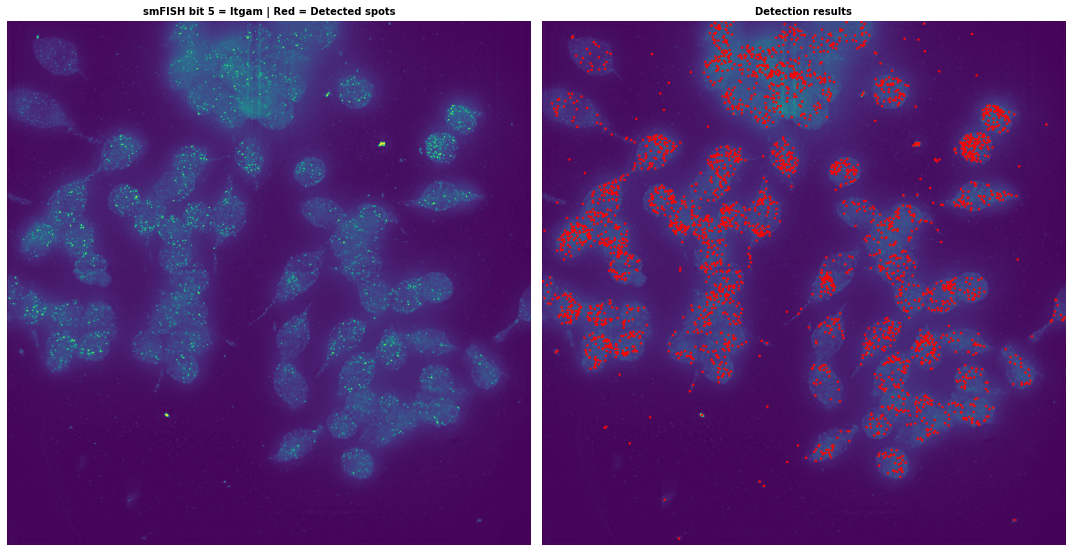

In [ ]:
plot.plot_detection(rna_mip, spots, contrast=True, title="smFISH bit 5 = Itgam | Red = Detected spots")

The automated spot detection method tries to find the optimal threshold to discriminate actual spots from noisy blobs. If we plot the number of the spots detected as a function of threshold level we observe an **elbow curve**. The selected threhold is the one located in the breaking point of the curve. This curve can be plotted with `bigfish.plot.plot_elbow`.

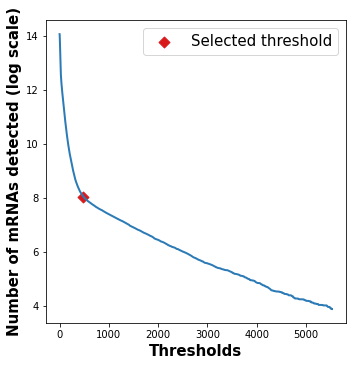

In [9]:
plot.plot_elbow(
    images=rna, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150))

## Dense region decomposition

The detection of local maximum is not able to detect individual spots clustered in a dense and bright region. We try to **decompose these regions by simulating as many spots as possible until we match the original region intensity**. Our current steps are:
- Denoise the smFISH channel by estimating then removing its background (`bigfish.stack.remove_background_gaussian`).
- Build a reference median spot from the individual predetected spots (`bigfish.detection.build_reference_spot`).
- Fit a gaussian signal on the reference spot (`bigfish.detection.modelize_spot`).
- Detect the candidate dense regions in the denoised image - large regions brighter than the reference spot (`bigfish.detection.get_dense_region`).
- Use the fitted gaussian signal to fill as many spots in the candidate regions as possible (`bigfish.detection.simulate_gaussian_mixture`).

All these steps are summarized in `bigfish.detection.decompose_dense` that return the 2D or 3D coordinates of the detected spots outside and inside a decomposed region, additional information about the regions themself and an image of the reference spot estimated.

In [17]:
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
    image=rna, 
    spots=spots, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150), 
    alpha=0.7,  # alpha impacts the number of spots per candidate region
    beta=1,  # beta impacts the number of candidate regions to decompose
    gamma=5)  # gamma the filtering step to denoise the image
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (3080, 3)
 dtype: int64 

detected spots after decomposition
 shape: (4070, 3)
 dtype: int64


The previous steps can be computed separately.

In [12]:
# gaussian kernel
kernel_size = detection.get_object_radius_pixel(
    voxel_size_nm=(300, 103, 103), 
    object_radius_nm=(350, 150, 150), 
    ndim=3)
large_kernel_size = tuple([kernel_size_ * 5 for kernel_size_ in kernel_size])

# denoising
rna_denoised = stack.remove_background_gaussian(rna, sigma=large_kernel_size)

# reference spot
reference_spot = detection.build_reference_spot(
    image=rna_denoised,
    spots=spots,
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150),
    alpha=0.7)

# fit a gaussian function on the reference spot
sigma_z, sigma_yx, amplitude, background = detection.modelize_spot(
    reference_spot=reference_spot, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150))

# detect dense regions
regions_to_decompose, spots_out_regions, region_size = detection.get_dense_region(
    image=rna_denoised, 
    spots=spots,
    voxel_size=(300, 103, 103),
    spot_radius=(350, 150, 150),
    beta=1)

# precompute gaussian function values
max_grid = max(200, region_size + 1)
precomputed_gaussian = detection.precompute_erf(
    ndim=3,
    voxel_size=(300, 103, 103),
    sigma=(sigma_z, sigma_yx, sigma_yx),
    max_grid=max_grid)

# simulate gaussian mixtures
spots_in_regions, _ = detection.simulate_gaussian_mixture(
    image=rna_denoised,
    candidate_regions=regions_to_decompose,
    voxel_size=(300, 103, 103),
    sigma=(sigma_z, sigma_yx, sigma_yx),
    amplitude=amplitude,
    background=background,
    precomputed_gaussian=precomputed_gaussian)

spots_post_decomposition = np.concatenate((spots_out_regions, spots_in_regions[:, :3]), axis=0)
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (771, 3)
 dtype: int64 

detected spots after decomposition
 shape: (1163, 3)
 dtype: int64


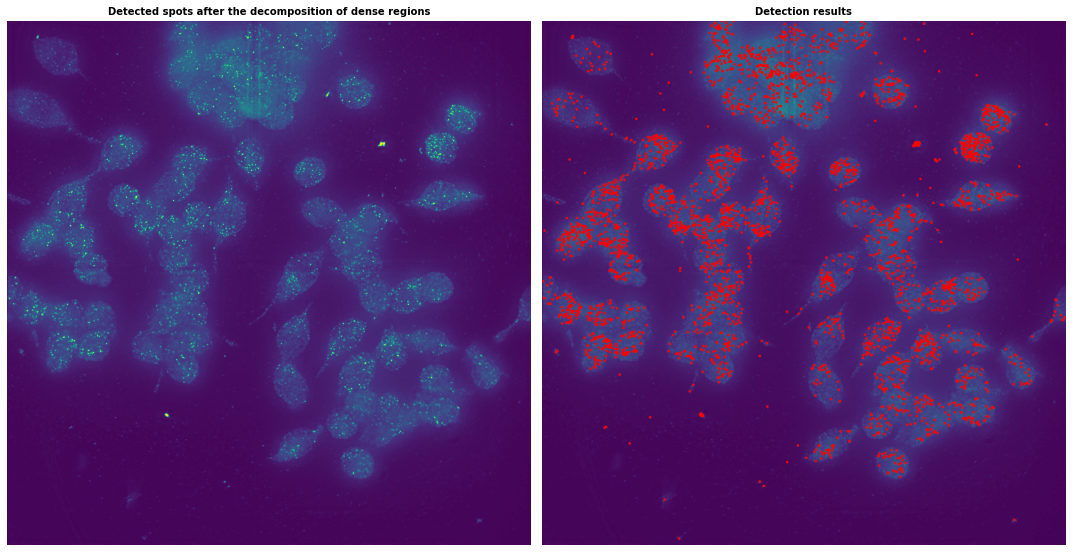

In [20]:
plot.plot_detection(rna_mip, spots_post_decomposition, contrast=True, title="Detected spots after the decomposition of dense regions")

The image of the **reference spot** can be used for safety checks. Indeed, a bad estimation would lead to a underestimate or overestimate the number of spots in the clusters. Enough samples of individual spots should be available to properly estimate a reference spot. 

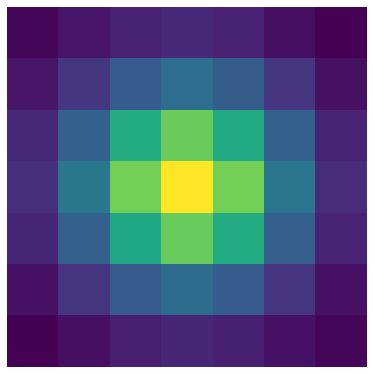

In [21]:
plot.plot_reference_spot(reference_spot, rescale=True)

## Clusters detection

Two spots are considered connected if they localized within a specific radius (in nanometer). Above a minimum number of connected spots, a cluster can be defined. This detection can be computed with `bigfish.detection.detect_clusters`.

In [23]:
spots_post_clustering, clusters = detection.detect_clusters(
    spots=spots_post_decomposition, 
    voxel_size=(300, 103, 103), 
    radius=350, 
    nb_min_spots=4)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

detected spots after clustering
 shape: (4070, 4)
 dtype: int64 

detected clusters
 shape: (56, 5)
 dtype: int64


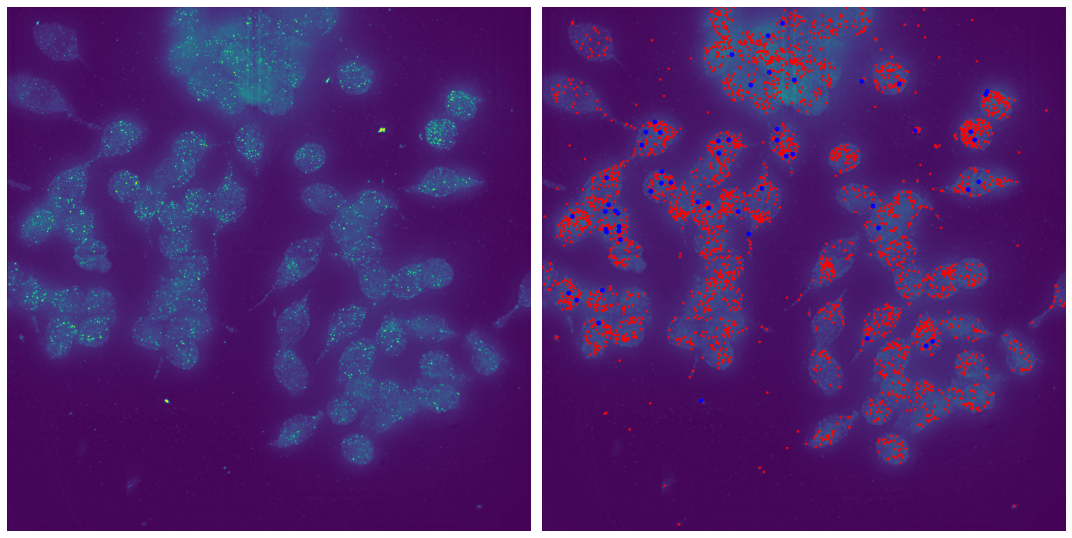

In [24]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, clusters[:, :3]], 
                    shape=["circle", "polygon"], 
                    radius=[3, 6], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    contrast=True)

## Additional detection methods

We crop a part of our smFISH channel to better visualize the results of the next methods. Especially, we look at a region without too many clustered spots because it could negativally impact **subpixel fitting** and **colocalized spots detection**. 

smfish channel (crop)
 shape: (63, 90, 100)
 dtype: uint16 



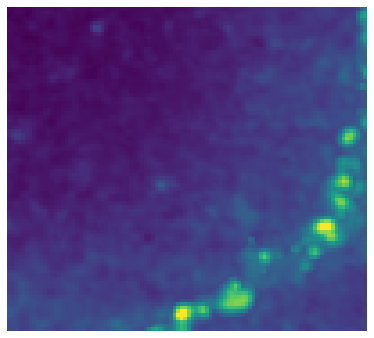

In [25]:
# crop
crop = rna[:, 520:610, 270:370]
crop_mip = rna_mip[520:610, 270:370]
print("smfish channel (crop)")
print("\r shape: {0}".format(crop.shape))
print("\r dtype: {0}".format(crop.dtype), "\n")

# plot
plot.plot_images(crop_mip, contrast=True, framesize=(5, 5))

### Subpixel fitting

If you analyze few isolated spots, it is possible to refine spots detections at the subpixel level with `bigfish.detection.fit_subpixel` (in 2D and 3D).

In [26]:
# pixel fitting
spots_crop = detection.detect_spots(
    images=crop,
    threshold=355.0,  # previous threshold automatically find in the full image
    voxel_size=(300, 103, 103),
    spot_radius=(350, 150, 150))
print("spots (pixel fitting)")
print("\r shape: {0}".format(spots_crop.shape))
print("\r dtype: {0}".format(spots_crop.dtype), "\n")

# subpixel fitting
spots_subpixel_crop = detection.fit_subpixel(
    image=crop, 
    spots=spots_crop, 
    voxel_size=(300, 103, 103), 
    spot_radius=(350, 150, 150))
print("spots (subpixel fitting)")
print("\r shape: {0}".format(spots_subpixel_crop.shape))
print("\r dtype: {0}".format(spots_subpixel_crop.dtype))

spots (pixel fitting)
 shape: (10, 3)
 dtype: int64 

spots (subpixel fitting)
 shape: (10, 3)
 dtype: float64


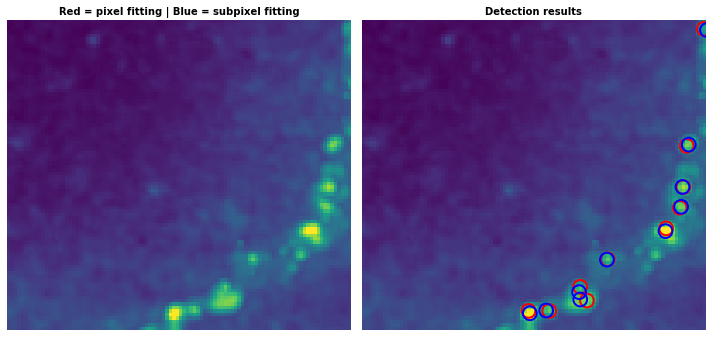

In [27]:
# plot
plot.plot_detection(
    crop_mip, 
    spots=[spots_crop, spots_subpixel_crop], 
    radius=2, 
    color=["red", "blue"],
    title="Red = pixel fitting | Blue = subpixel fitting",
    linewidth=2, contrast=True, framesize=(10, 5))

### Colocalization

To detect colocalized spots (over different channels), the function `bigfish.multistack.detect_spots_colocalization` is available. Here, as an example, we detect colocalized spots between the ones detected with a pixel accuracy and the ones with subpixel accuracy. Like the regular spot detection, if a threshold is not provided to discriminate colocalized spots from distant ones, the function tries to set one, automatically.

In [28]:
(spots_1_colocalized, spots_2_colocalized, 
 distances, 
 indices_1, indices_2, 
 threshold) = multistack.detect_spots_colocalization(
    spots_1=spots_crop, 
    spots_2=spots_subpixel_crop,
    voxel_size=(300, 103, 103),
    return_indices=True,
    return_threshold=True)
print("colocalized spots")
print("\r shape 1: {0}".format(spots_1_colocalized.shape))
print("\r shape 2: {0}".format(spots_2_colocalized.shape))
print("\r distances: {0}".format(distances.shape))
print("\r indices 1: {0}".format(indices_1.shape))
print("\r indices 2: {0}".format(indices_2.shape))
print("\r threshold: {0:0.2f} nm".format(threshold))

colocalized spots
 shape 1: (9, 3)
 shape 2: (9, 3)
 distances: (9,)
 indices 1: (9,)
 indices 2: (9,)
 threshold: 318.48 nm


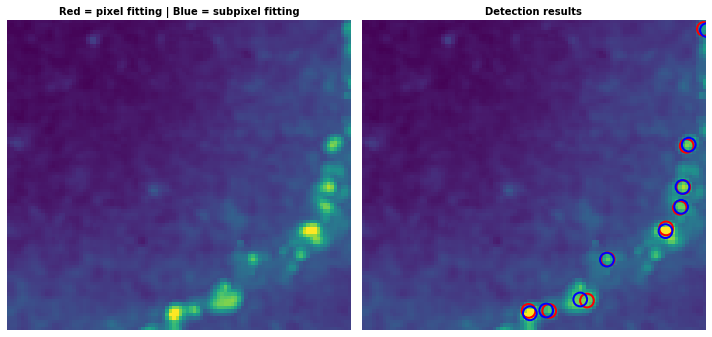

In [29]:
# plot
plot.plot_detection(
    crop_mip, 
    spots=[spots_1_colocalized, spots_2_colocalized], 
    radius=2, 
    color=["red", "blue"],
    title="Red = pixel fitting | Blue = subpixel fitting",
    linewidth=2, contrast=True, framesize=(10, 5))

Using the same logic than `bigfish.plot.plot_elbow`, the automated colocalized spot detection method tries to find the optimal threshold to discriminate colocalized spots from distant ones. One can use `bigfish.plot.plot_elbow_colocalized` to visualize the impact of the threshold on the colocalization.

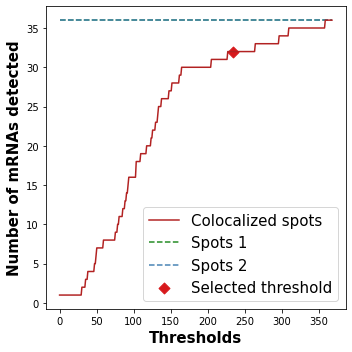

In [22]:
plot.plot_elbow_colocalized(
    spots_1=spots_crop, 
    spots_2=spots_subpixel_crop, 
    voxel_size=(300, 103, 103))

## Save results

Spots and foci coordinates can be saved in **npy files** (numpy dedicated format) or **csv files** using functions `bigfish.stack.save_array` and `bigfish.stack.save_data_to_csv` respectively.

In [30]:
# save in npy files
path = os.path.join(path_output, "spots.npy")
stack.save_array(spots_post_clustering, path)
path = os.path.join(path_output, "clusters.npy")
stack.save_array(clusters, path)

# save in csv files
path = os.path.join(path_output, "spots.csv")
stack.save_data_to_csv(spots_post_clustering, path)
path = os.path.join(path_output, "clusters.csv")
stack.save_data_to_csv(clusters, path)

## Detection in 2D or 3D

Based on the number of dimensions of the provided image, a 2D or 3D detection is performed and corresponding coordinates are returned. Parameters `voxel_size` and `spot_radius` should be adapted to the number of dimensions.

In [31]:
spots, threshold = detection.detect_spots(
    images=rna_mip, 
    return_threshold=True, 
    voxel_size=(103, 103),  # in nanometer (one value per dimension yx)
    spot_radius=(150, 150))  # in nanometer (one value per dimension yx)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

detected spots
 shape: (2540, 2)
 dtype: int64
 threshold: 331.0


In [32]:
spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
    image=rna_mip, 
    spots=spots, 
    voxel_size=(103, 103), 
    spot_radius=(150, 150), 
    alpha=0.7,  # alpha impacts the number of spots per candidate region
    beta=1,  # beta impacts the number of candidate regions to decompose
    gamma=5)  # gamma the filtering step to denoise the image
print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

detected spots before decomposition
 shape: (2540, 2)
 dtype: int64 

detected spots after decomposition
 shape: (3298, 2)
 dtype: int64


In [26]:
spots_post_clustering, clusters = detection.detect_clusters(
    spots=spots_post_decomposition, 
    voxel_size=(103, 103), 
    radius=350, 
    nb_min_spots=4)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

detected spots after clustering
 shape: (883, 3)
 dtype: int64 

detected clusters
 shape: (16, 4)
 dtype: int64


This is where the issue with the clusters coordinates happens! Something is going on with its coordinates where all the clusters are at the top of the plot. I think it has to do with their slicing.

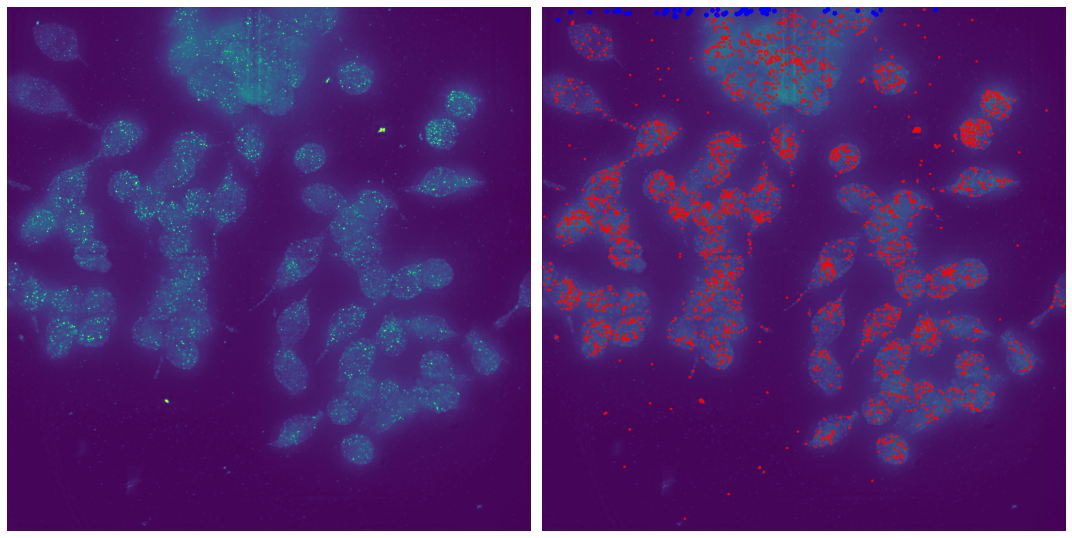

In [33]:
# plot
plot.plot_detection(rna_mip, 
                    spots=[spots_post_decomposition, clusters[:, :2]], 
                    shape=["circle", "polygon"], 
                    radius=[3, 6], 
                    color=["red", "blue"],
                    linewidth=[1, 2], 
                    fill=[False, True], 
                    contrast=True)